In [1]:
import os
import torch
import numpy as np
import random
from utils import buildDataset

## build dataset

In [2]:
defaultStrategy = "./DefaultStrategy.txt"
defaultOutput = "./defaultOutputs.txt"
strategy = "./strategy.txt"
output = "./outputs.txt"
dataset = buildDataset.getData(strategy, output, defaultStrategy, defaultOutput)

In [3]:
len(dataset)

77

In [4]:
dataset[0]

[[{'size': 7,
   'offset': 0,
   'mazeEndIter': 3,
   'MarkerCost': 0,
   'FixedShapeCost': 8,
   'Decay': 0.95,
   'ripupMode': 0,
   'followGuide': 1},
  10178],
 [{'size': 7,
   'offset': -2,
   'mazeEndIter': 3,
   'MarkerCost': 8,
   'FixedShapeCost': 8,
   'Decay': 0.95,
   'ripupMode': 0,
   'followGuide': 1},
  569],
 [{'size': 7,
   'offset': -5,
   'mazeEndIter': 3,
   'MarkerCost': 8,
   'FixedShapeCost': 8,
   'Decay': 0.95,
   'ripupMode': 0,
   'followGuide': 1},
  499],
 [{'size': 7,
   'offset': 0,
   'mazeEndIter': 8,
   'MarkerCost': 32,
   'FixedShapeCost': 16,
   'Decay': 0.95,
   'ripupMode': 1,
   'followGuide': 0},
  1],
 [{'size': 7,
   'offset': -1,
   'mazeEndIter': 8,
   'MarkerCost': 32,
   'FixedShapeCost': 16,
   'Decay': 0.95,
   'ripupMode': 1,
   'followGuide': 0},
  0]]

# Turning datapoint to tensor

To represent a single data point input, we use a tensor of size <No_Strategy x 1 x 9>. (9 includes 8 DRC sequence items, and 1 output DRC value)

In [5]:
Dataset = buildDataset.datasetToTensor(dataset)

In [6]:
len(Dataset)

77

In [7]:
Dataset[0]

tensor([[[ 7.0000e+00,  0.0000e+00,  3.0000e+00,  0.0000e+00,  8.0000e+00,
           9.5000e-01,  0.0000e+00,  1.0000e+00,  1.0178e+04]],

        [[ 7.0000e+00, -2.0000e+00,  3.0000e+00,  8.0000e+00,  8.0000e+00,
           9.5000e-01,  0.0000e+00,  1.0000e+00,  1.0178e+04]],

        [[ 7.0000e+00, -5.0000e+00,  3.0000e+00,  8.0000e+00,  8.0000e+00,
           9.5000e-01,  0.0000e+00,  1.0000e+00,  5.6900e+02]],

        [[ 7.0000e+00,  0.0000e+00,  8.0000e+00,  3.2000e+01,  1.6000e+01,
           9.5000e-01,  1.0000e+00,  0.0000e+00,  4.9900e+02]],

        [[ 7.0000e+00, -1.0000e+00,  8.0000e+00,  3.2000e+01,  1.6000e+01,
           9.5000e-01,  1.0000e+00,  0.0000e+00,  1.0000e+00]]])

In [8]:
Dataset[0].size()

torch.Size([5, 1, 9])

# train-test split of the dataset

In [9]:
trainningSet, testSet = buildDataset.splitDataset(Dataset, trainSize = 0.7)

In [10]:
len(trainningSet)

53

In [11]:
len(testSet)

24

In [12]:
trainningSet[0]

tensor([[[  7.0000,   0.0000,   3.0000,   0.0000,   8.0000,   0.9500,   0.0000,
            1.0000, 205.0000]],

        [[  7.0000,  -2.0000,   3.0000,   8.0000,   8.0000,   0.9500,   0.0000,
            1.0000, 205.0000]],

        [[  7.0000,  -5.0000,   3.0000,   8.0000,   8.0000,   0.9500,   0.0000,
            1.0000,  10.0000]],

        [[  7.0000,   0.0000,   8.0000,  32.0000,  16.0000,   0.9500,   1.0000,
            0.0000,   7.0000]]])

In [13]:
trainningSet[0].size()

torch.Size([4, 1, 9])

# Creating the Network

In [14]:
# reference: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, inputData, hidden):
        combined = torch.cat((inputData, hidden), dim=1)
        hidden = self.i2h(self.relu(combined))
        output = self.h2o(self.relu(hidden))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [15]:
n_input = len(trainningSet[0][0][0])
n_hidden = 128

In [16]:
n_input

9

In [17]:
n_output = 1

In [18]:
rnn = RNN(n_input, n_hidden, n_output)

# Run a step of the network

To run a step of this network we need to pass an input (in our case, the Tensor for the current strategy) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of drcs) and a next hidden state (which we keep for the next step).

In [19]:
import torch

In [20]:
inputStrategy = trainningSet[0][0]
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(inputStrategy, hidden)

In [21]:
next_hidden

tensor([[ 10.2733,  -5.4157,   4.0527,  -5.2640,  15.0990, -14.5151,  10.2025,
          14.9126, -12.7203,  17.1421, -14.5290,   3.3869,   1.2967,   8.5711,
           6.6895,  -7.9834,  -2.7663,   4.7589,  -8.3400, -16.9978,  10.0051,
          14.8295, -10.1739,   9.1431, -16.9060, -13.3824,   4.2763,  -1.1257,
          -0.1408, -11.4924,  13.2630,  16.3501,   2.1801,  11.6305, -12.8360,
           2.6284,  13.1002, -10.7731,  15.7131,   3.6854,  15.0614,   1.4792,
           2.0799,   9.2900,  -1.6103,  -3.4338,   6.1251,  -7.5789,   5.8351,
         -15.7476,  12.3593,  -9.0797,  -8.2012,  -7.7256, -14.6811,   5.4273,
         -14.2795,  -9.2777,  -2.5446,   7.1093, -17.2309,  -2.2482, -17.1392,
           1.0100, -16.4288,  -2.4497,  -6.9073,  12.7852,   4.6345,   4.5517,
          14.3789,  10.9578,  -4.4391,   1.3161, -10.1629,  -0.8592,   9.0096,
          -7.4772,  14.0926,   0.7823,   3.1764,  -4.8885,  -6.0693,  -1.3196,
          -3.4479,   6.8127,  -8.7889,   4.7104, -11

In [22]:
output

tensor([[-6.4678]], grad_fn=<AddmmBackward0>)

# Training

In [23]:
criterion = nn.MSELoss()

In [24]:
learning_rate = 0.001 # If you set this too high, it might explode. If too low, it might not learn

In [25]:
import torch.optim as optim
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

In [28]:
n_iters = 100
print_every = 10
plot_every = 1

In [29]:
def train(x):
    hidden = rnn.initHidden()
    y = torch.zeros(1, n_output)
    
    rnn.zero_grad()

    for i in range(x.size()[0]):
        output, hidden = rnn(x[i], hidden)

    loss = criterion(output, y)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [30]:
import time
import math

In [31]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

In [32]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

In [33]:
for iter in range(1, n_iters + 1):
    # randomly generate an index in training set
    index = random.randint(0, len(trainningSet) - 1)
    x = trainningSet[index]
    output, loss = train(x)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        print('%d %d%% (%s) %.4f' % (iter, iter / n_iters * 100, timeSince(start), loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

10 10% (0m 0s) nan
20 20% (0m 0s) nan
30 30% (0m 0s) nan
40 40% (0m 0s) nan
50 50% (0m 0s) nan
60 60% (0m 0s) nan
70 70% (0m 0s) nan
80 80% (0m 0s) nan
90 90% (0m 0s) nan
100 100% (0m 0s) nan


# Result evaluation

In [34]:
# print("MSE: %.2f" % best_mse)
# print("RMSE: %.2f" % np.sqrt(best_mse))
# plt.plot(history)
# plt.show()

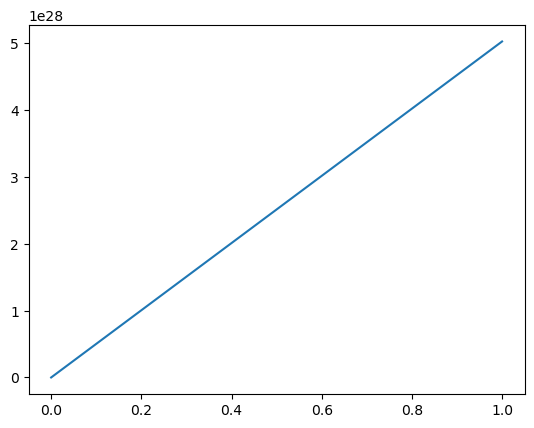

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [36]:
all_losses

[229.59442138671875,
 5.027129598444769e+28,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

# Running one unseen inputs

In [37]:
# Just return an output given an input
def evaluate(x):
    hidden = rnn.initHidden()
    result = []
    
    for i in range(x.size()[0]):
        output, hidden = rnn(x[i], hidden)
        result.append(output)

    return result

In [38]:
def predict(x):
    with torch.no_grad():
        result = evaluate(x)
    return result

In [39]:
results = []
for index in range(len(testSet)):
    x = testSet[index]
    output = predict(x)
    results.append(output)

In [40]:
results[0]

[tensor([[nan]]),
 tensor([[nan]]),
 tensor([[nan]]),
 tensor([[nan]]),
 tensor([[nan]])]